## Установка зависимостей

In [57]:
%pip install pandas numpy matplotlib seaborn scipy scikit-learn huggingface_hub

Note: you may need to restart the kernel to use updated packages.


## Импорты

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.datasets import fetch_california_housing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Загрузка датасета (используем числовой датасет California Housing)

In [59]:
data = fetch_california_housing(as_frame=True)
df = data.frame

print("Первичный осмотр данных")
print(df.info())
print(df.describe())

Первичный осмотр данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None
         MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
count 20640.000 20640.000 20640.000  20640.000   20640.000 20640.000   
mean      3.871    28.639     5.429      1.097    1425.477     3.071   
std       1.900    12.586     2.474      0.474    1132.462    10.386   
min       0.500     1.000     0.846      0.333       3.000     0.692   
2

## Поиск выбросов

In [60]:
# Выберем признаки с потенциальными выбросами: AveRooms, AveBedrms, Population
target_cols = ['AveRooms', 'AveBedrms', 'Population']

z_scores = np.abs(stats.zscore(df[target_cols]))
threshold = 3
outliers_mask = (z_scores > threshold).any(axis=1)

print(f"Найдено строк с выбросами (Z-score > 3): {outliers_mask.sum()}")

Найдено строк с выбросами (Z-score > 3): 501


## Очистка данных

In [61]:
df_dropped = df[~outliers_mask].copy()

df_filled = df.copy()
for col in target_cols:
    median = df[col].median()
    std = df[col].std()
    mean = df[col].mean()
    df_filled.loc[np.abs((df[col] - mean) / std) > threshold, col] = median

## Сравнение распределений до и после

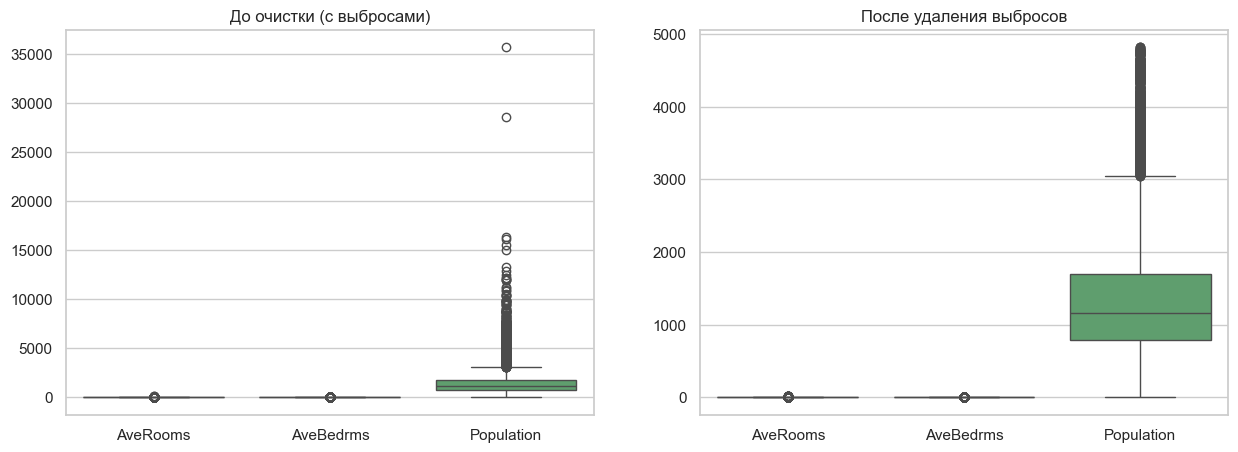

In [62]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=df[target_cols])
plt.title("До очистки (с выбросами)")

plt.subplot(1, 2, 2)
sns.boxplot(data=df_dropped[target_cols])
plt.title("После удаления выбросов")
plt.show()

## Анализ с помощью PCA

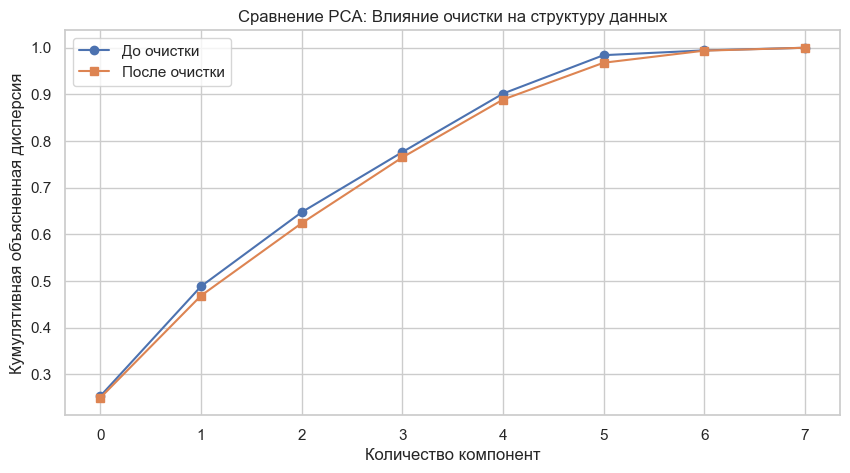

In [63]:
def check_pca(data_frame):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_frame.drop('MedHouseVal', axis=1))
    pca = PCA()
    pca.fit(scaled_data)
    return np.cumsum(pca.explained_variance_ratio_)

pca_before = check_pca(df)
pca_after = check_pca(df_dropped)


plt.figure(figsize=(10, 5))
plt.plot(pca_before, label='До очистки', marker='o')
plt.plot(pca_after, label='После очистки', marker='s')
plt.xlabel('Количество компонент')
plt.ylabel('Кумулятивная объясненная дисперсия')
plt.title('Сравнение PCA: Влияние очистки на структуру данных')
plt.legend()
plt.grid(True)
plt.show()

## Отбор признаков по корреляции

In [64]:
corr_matrix = df_dropped.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print(f"Признаки к удалению (корреляция > 0.8): {to_drop}")

df_final = df_dropped.drop(columns=to_drop)
print(f"Итоговое количество признаков: {df_final.shape[1]}")

Признаки к удалению (корреляция > 0.8): ['Longitude']
Итоговое количество признаков: 8


## Финальная визуализация матрицы корреляций

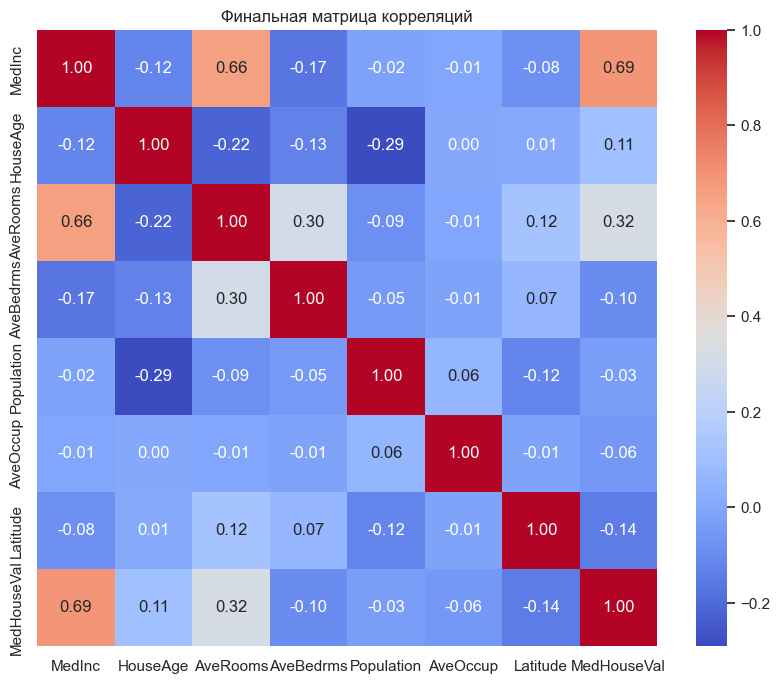

In [65]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_final.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Финальная матрица корреляций")
plt.show()